# Matlab Implementation - Track Kalman

<img src= "plot_position.png" width ="500">


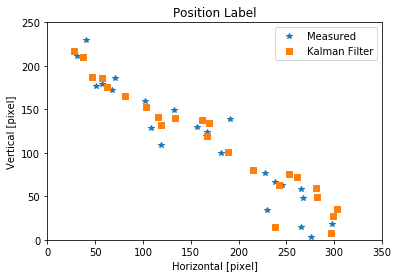

In [2]:
import numpy as np
import matplotlib.pyplot as plot
import KalmanTools as Tools
from csv import reader

def GetBallPos():
    filename = "Measure_Img.csv"
    X, Y = [], []

    with open(filename ,"r") as file_obj:
        file = reader(file_obj)
        for line in file:
            X.append(float(line[0]))
            Y.append(float(line[1]))

    i = 0
    while i < len(X):
        yield X[i], Y[i]
        i +=1



NoOfImg = 24
dt = 1

Xhsaved = np.zeros((2,NoOfImg))
Xmsaved = np.zeros((2,NoOfImg))
XmRead = GetBallPos()

TrackKalman = Tools.KalmanFilter()

A = np.matrix([[1,dt, 0, 0],
		       [0, 1, 0, 0],
		       [0, 0, 1,dt],
		       [0, 0, 0, 1]])

H = np.matrix([[1, 0, 0, 0],
               [0, 0, 1, 0]])

Q = np.eye(4)
R = np.eye(2)*50
x = np.zeros((4,1))
P = np.eye(4)*100

TrackKalman.setDeltaT(dt)
TrackKalman.setTransitionMatrix(A)
TrackKalman.setSttMeasure(H)
TrackKalman.setTransitionCovMatrix(Q)
TrackKalman.setErrorCovMatrix(P)
TrackKalman.setMeasureCovMatrix(R)
TrackKalman.setSttVariable(x)


for i in range(NoOfImg):
	xm, ym = Xmsaved[0:2, i] = next(XmRead)
	result = TrackKalman.filter(xm, ym)
	Xhsaved[0:2, i] = result


# plotting results
xy, position = plot.subplots()


position.plot(Xmsaved[0], Xmsaved[1], '*', label='Measured')
position.plot(Xhsaved[0], Xhsaved[1], 's', label='Kalman Filter')
position.set(title="Tracking Posion", xlabel="Horizontal [pixel]", ylabel="Vertical [pixel]")
position.set_ylim([0,250])
position.set_xlim([0,350])
position.legend()


plot.show()

# KalmanTools Class Implementation (Python)

In [1]:
%%writefile KalmanTools.py
import numpy as np 

class KalmanFilter(object):
	def __init__(self):
		#initial Variables
		self.A = np.matrix
		self.H = np.matrix
		self.Q = np.matrix
		self.R = np.matrix
		self.x = np.matrix
		self.P = np.matrix
		self.dt : float
		self.z : float
		self.K = np.matrix

	def setTransitionMatrix(self, A):
		self.A = A
        
	def setSttMeasure(self, H):
		self.H = H

	def setSttVariable(self, x):
		self.x = x

	def setTransitionCovMatrix(self, Q):
		self.Q = Q

	def setMeasureCovMatrix(self, R):
		self.R = R

	def setDeltaT(self, delta):
		self.dt = delta

	def setErrorCovMatrix(self, P):
		self.P = P

	def filter(self, dx, dy):
		self.z = np.matrix([[dx], [dy]])
		xp = self.A * self.x
		Pp = self.A * self.P * self.A.getT() + self.Q
		self.K = Pp * self.H.getT() * np.matrix.getI(self.H * Pp * self.H.getT() + self.R)
		self.x = xp + self.K * (self.z - self.H * xp)
		self.P = Pp - self.K * self.H * Pp
		dv_pos = self.x[0, 0]
		dv_vel = self.x[2, 0]
		return dv_pos, dv_vel


Overwriting KalmanTools.py



# DPC++ implementation

In [2]:
%%writefile TestTrackKalman.cpp
#include <iostream>
using std::cout;
using std::endl;

#include <vector>
using std::vector; 

#include <fstream>
using std::ifstream; 
using std::ofstream; 


#include <stdlib.h>
#include <string>
using std::stof;
using std::string;

#include <limits>
#include <random>
#include <CL/sycl.hpp>
#include "oneapi/mkl.hpp"
namespace blas = oneapi::mkl::blas;
namespace lapack = oneapi::mkl::lapack;

#include "KalmanTools.h"


// Struct to store measures (x,y):
struct coordenadas
{
	long double X ;
	long double Y;

};

//Function Prototype
coordenadas *GetCoordenadas();


int main(){
    //create file : TestTrackFile.csv
    ofstream myfile("TestTrack.csv");
    myfile << "Xmsaved,Ymsaved,Xhsaved,Yhsaved\n";
    auto async_handler = [](sycl::exception_list exceptions) {
        for (exception_ptr const &e : exceptions) {
            try {
                rethrow_exception(e);
            }
            catch (sycl::exception const &e) {
                cout << "Caught asynchronous SYCL exception: " << e.what() << endl;
            }
        }
    };
    
    try {
        //Define pseudo-random values and normal distribution
        default_random_engine generator;
        generator.seed(42);
        normal_distribution<double> distribution(0.0, 1.0);
         
        //About Accelerator Device & Queue
        sycl::device device = sycl::device(sycl::default_selector());
        cout << "Device: " << device.get_info<sycl::info::device::name>() << "\n";
        sycl::queue queue(device, async_handler);
        vector<sycl::event> event_list;
        
        //Declare example variables, lists and Kalman Object
        double dt = 1;
        const int Nsamples = 24;
        
        double t[Nsamples];
        Kalman_filter *kalman = new Kalman_filter();
        auto *Xmsaved = sycl::malloc_shared<double>(Nsamples, queue);
        auto *Ymsaved = sycl::malloc_shared<double>(Nsamples, queue);
        
        auto *Xhsaved = sycl::malloc_shared<double>(Nsamples, queue);
        auto *Yhsaved = sycl::malloc_shared<double>(Nsamples, queue);
        
        
        auto *A = sycl::malloc_shared<double>(4 * 4, queue);
        A[0]  = 1; A[1] = dt; A[2]  = 0; A[3]  = 0;
        A[4]  = 0; A[5]  = 1; A[6]  = 0; A[7]  = 0;
        A[8]  = 0; A[9]  = 0; A[10] = 1; A[11] =dt;
        A[12] = 0; A[13] = 0; A[14] = 0; A[15] = 1;
        
        
        auto *H = sycl::malloc_shared<double>(2 * 4, queue);
        H[0]  = 1; H[1] = 0; H[2] = 0; H[3] = 0;
        H[4]  = 0; H[5] = 0; H[6] = 1; H[7] = 0;
        
        auto *Q = sycl::malloc_shared<double>(4 * 4, queue);
        Q[0]  = 1; Q[1]  = 0; Q[2]  = 0; Q[3]  = 0;
        Q[4]  = 0; Q[5]  = 1; Q[6]  = 0; Q[7]  = 0;
        Q[8]  = 0; Q[9]  = 0; Q[10] = 1; Q[11] = 0;
        Q[12] = 0; Q[13] = 0; Q[14] = 0; Q[15] = 1;
        
        auto *R = sycl::malloc_shared<double>(2 * 2, queue);
        R[0] = 50; R[1] = 0;
        R[2] = 0; R[3] = 50;     
        
        auto *x = sycl::malloc_shared<double>(4 * 1, queue);
        x[0] = 0; x[1] = 0; x[2]  = 0; x[3] = 0;     
        
        auto *P = sycl::malloc_shared<double>(4 * 4, queue);
        P[0] =100; P[1]  = 0; P[2]  = 0; P[3]  = 0;
        P[4]  = 0; P[5] =100; P[6]  = 0; P[7]  = 0;
        P[8]  = 0; P[9]  = 0; P[10]=100; P[11] = 0;
        P[12] = 0; P[13] = 0; P[14] = 0; P[15]=100;
        kalman->setDeltaT(dt);
        kalman->setTransitionMatrix(A);
        kalman->setSttMeasure(H);
        kalman->setSttVariable(x);
        kalman->setTransitionCovMatrix(Q);
        kalman->setMeasureCovMatrix(R);
        kalman->setErrorCovMatrix(P);
        //generate list with Coordinate measures
        coordenadas *Measure = GetCoordenadas();
        
        
        if (!Yhsaved || !Xhsaved) {
            cerr << "Could not allocate memory for vectors." << endl;
            exit(1);
        }
        
        int first = 0;
        double xm, ym, xh, yh;
        for (int i = 0; i < Nsamples; i++){  
            //Store initial values obtained previously
            t[i] = i;
            xm = Xmsaved[i] = Measure[i].X;
            ym = Ymsaved[i] = Measure[i].Y;
            
            //calculate, then store on arrays
            kalman->filter(xm, ym);
            xh = Xhsaved[i] = kalman->getResult(0,0);
            yh = Yhsaved[i] = kalman->getResult(2,0);
            
            //Save the results below in myfile. 
            myfile << xm <<", "<< ym << ", " << xh << ", " << yh <<'\n';
        }
        myfile.close();
        free(Yhsaved, queue);
        free(Xhsaved, queue);
        kalman->end_task();

    } catch (const exception &e) {
        cerr << "An exception occurred: "
                  << e.what() << endl;
        exit(1);
    }
}

coordenadas *GetCoordenadas(){
	string txt, name = "Measure_Img.csv";
	const int Ncoord = 24;
	coordenadas *Coord = new coordenadas[Ncoord];
	coordenadas *Pointer = Coord; 
	std::ifstream Arquivo(name);
	long double x , y;
	int pos, len , i = 0;
	while(getline(Arquivo, txt)){
		
		pos = txt.find(",");
		len = txt.length();
		x = std::stold(txt.substr(0, pos));

		y = std::stold(txt.substr(pos+1, len-1));
		Coord[i].X = x;
		Coord[i].Y = y;
		i++;
		}
		return Pointer;
}


Overwriting TestTrackKalman.cpp


# KalmanTools Class Implementation (DPC++)

In [3]:
%%writefile KalmanTools.h


#include <iostream>

#include <fstream>
#include <stdlib.h>
#include <stdio.h>
#include <limits>
#include <CL/sycl.hpp>
#include "oneapi/mkl.hpp"

#include <algorithm> 

#include <iomanip>
using std::setw;

namespace blas = oneapi::mkl::blas;
namespace lapack = oneapi::mkl::lapack;
using namespace std;

auto nontransM = oneapi::mkl::transpose::nontrans;
auto    transM = oneapi::mkl::transpose::trans;

void inv(sycl::queue &queue, double *A, int64_t N) {
    sycl::event getr_task[2];
    vector<sycl::event> event_list;

    double scratch_size = lapack::getrf_scratchpad_size<double>(queue, N, N, N);
    double *scratchpad = sycl::malloc_shared<double>(scratch_size+1, queue);

    auto *IPIV = sycl::malloc_shared<int64_t>(N*N, queue);
    
    getr_task[0] = lapack::getrf(queue, N, N, A, N, IPIV, scratchpad, scratch_size, event_list);
    getr_task[0].wait();
    getr_task[1] = lapack::getri(queue, N, A, N, IPIV, scratchpad, scratch_size, event_list);
    getr_task[1].wait();
    
    free(IPIV, queue);
}
class Kalman_filter {
private: 
    sycl::queue queue;
    double alpha = 1.0; 
    double beta = 0.0;
    int M = 4;
    int N = 2;
    int L = 1; 
    double dt;
    
    const int size_1 = N*N;
    const int size_2 = M*N;
    const int size_3 = M*M;
    
    const int size_4 = M*L;

    //Matrix Pointers
    double *A;
    double *H;
    double *Q;
    double *R;
    double *x;
    double *P;
    double *z = sycl::malloc_shared<double>(N * L, queue);


    // Intermediary values to calculus
    double *xp    = sycl::malloc_shared<double>(M * L, queue);
    double *Pp    = sycl::malloc_shared<double>(M * M, queue);
    double *K     = sycl::malloc_shared<double>(M * N, queue);
    double *AP    = sycl::malloc_shared<double>(M * M, queue);   
    double *PpHT  = sycl::malloc_shared<double>(N * N, queue); 
    double *HpHTR = sycl::malloc_shared<double>(N * N, queue);
    double *Hxp   = sycl::malloc_shared<double>(N * L, queue);
    double *KH    = sycl::malloc_shared<double>(M * M, queue); 

public: 
    //modules
    void filter(double x, double y);
    double getResult(int row, int col);
    
   void setDeltaT( double setdt );
    void setTransitionMatrix(double *Aset);
    void setSttMeasure(double * Hset);
    void setSttVariable(double * xset);
    void setTransitionCovMatrix(double * Q);
    void setMeasureCovMatrix(double * Rset);
    void setErrorCovMatrix(double * P);
    
    void end_task();
};



void Kalman_filter::setDeltaT( double setdt ){
    dt = setdt;
}

void Kalman_filter::setTransitionMatrix(double *Aset){
    A = Aset;
}

void Kalman_filter::setSttMeasure(double * Hset){
    H = Hset;
}

void Kalman_filter::setSttVariable(double * xset){
    x = xset;    
}

void Kalman_filter::setTransitionCovMatrix(double * Qset){
    Q = Qset;
}

void Kalman_filter::setMeasureCovMatrix(double * Rset){
    R = Rset;
}

void Kalman_filter::setErrorCovMatrix(double * Pset){
    P = Pset;
}      

void Kalman_filter::filter(double dx, double dy){

    z[0] = dx; z[1] = dy;
    
    constexpr int gemm_total = 10, axpy_total = 5;
    sycl::event gemm_task[gemm_total], scal_task;
    sycl::event axpy_task[axpy_total];
    //std::cout<<std::showpoint;
    vector<sycl::event> gemm[gemm_total];
       
     // xp(MxL) = A(MxM) * x(MxL)
    gemm_task[0] = blas::row_major::gemm(queue, nontransM, nontransM, M, L, M, alpha, A, M, x, L, beta, xp, L, gemm[0]);
    gemm_task[0].wait();

    
     // Pp(MxM) = A * P * A' + Q(MxM) 
        //1.1) AP(MxM) = A(MxM) * P(MxM)
    gemm_task[1] = blas::row_major::gemm(queue, nontransM, nontransM, M, M, M, alpha, A, M, P, M, beta, AP, M, gemm[1]);
    gemm_task[1].wait();
    
        //1.2) Pp = AP(MxM) * A'(MxM) 
    gemm_task[2] = blas::row_major::gemm(queue, nontransM, transM, M, M, M, alpha, AP, M, A, M, beta, Pp, M, gemm[2]);
    gemm_task[2].wait();
    
    
        //1.3) Pp(MxM) = Pp(MxM) + Q(MxM)  
    axpy_task[0] = blas::axpy(queue, M*M, alpha, Q, 1.0, Pp, 1.0);
    axpy_task[0].wait();
      
    // K = Pp * H' * inv(H * Pp * H' + R)
        // 2.1) PpHT(MxN) = Pp(MxM) * H'(MxN) 
    gemm_task[3] = blas::row_major::gemm(queue, nontransM, transM, M, N, M, alpha, Pp, M, H, M, beta, PpHT, N, gemm[3]);
    gemm_task[3].wait();

    
        // 2.2) HpHTR(NxN) = H(NxM) * [ Pp(MxM) * Ht(MxN) ] = H (NxM) * PpHT(MxN) 
    gemm_task[4] = blas::row_major::gemm(queue, nontransM, nontransM, N, N, M, alpha, H, M, PpHT, N, beta, HpHTR, N, gemm[4]);
    gemm_task[4].wait();
                                       
        // 2.3) HpHTR(NxN) = HpHTR(NxN) + R(NxN) //alterado (N*N)
    axpy_task[1] = blas::axpy(queue, N*N, alpha, R, 1.0, HpHTR, 1.0);
    axpy_task[1].wait();
    
        // HpHTR(NxN) = inv(HpHTR)
    inv(queue, HpHTR, N);                                
    
         // 2.4) K(MxN) = (Pp(MxM) * Ht(MxN)) * HpHTR(NxN) -> PpHT(MxN) * HpHTR(NxN) // ok 
    gemm_task[5] = blas::gemm(queue, nontransM, nontransM, M, N, N, alpha, PpHT, M, HpHTR, N, beta, K, M, gemm[5]);
    gemm_task[5].wait();


    // x(MxK) = xp(MxK) + K * (z - H * xp)
        // 3.1) Hxp(NxL) = H(NxM) * xp(MxL)
    gemm_task[6] = blas::row_major::gemm(queue, nontransM, nontransM, N, L, M, alpha, H, M, xp, L, beta, Hxp, L, gemm[6]);
    gemm_task[6].wait();
    
        // 3.2) z(NxL) = -Hxp(NxL) + z(NxL)
    axpy_task[2] = blas::axpy(queue, N * L, -alpha, Hxp, 1.0, z, 1.0);
    axpy_task[2].wait();
                                                                      
        //3.3) // x(MxL) = K(MxN)*z(NxL)
    gemm_task[7] = blas::row_major::gemm(queue, nontransM, nontransM, M, L, N, alpha, K, N, z, L, beta, x, L, gemm[7]);
    gemm_task[7].wait();
    
    
    
        //3.4) x(MxL) = xp(MxL) + x(MxL)
    axpy_task[3] = blas::axpy(queue, M*L, alpha, xp, 1.0, x, 1.0);
    axpy_task[3].wait();
    
    
    // P = Pp - K * H * Pp
        //4.1) KH(MxM) = K(MxN)*H(NxM)
    gemm_task[8] = blas::row_major::gemm(queue, nontransM, nontransM, M, M, N, alpha, K, N, H, M, beta, KH, M, gemm[8]);
    gemm_task[8].wait();

        //4.2) P(MxM) =(-1)* KH(MxM) * Pp(MxM) 
    gemm_task[9] = blas::row_major::gemm(queue, nontransM, nontransM, M, M, M, -alpha, KH, M, Pp, M, beta, P, M, gemm[9]);
    gemm_task[9].wait();
    
        //4.3) P(MxM) = (Pp - P) 
    axpy_task[4] = blas::axpy(queue, M * M, alpha, Pp, 1.0, P, 1.0);
    axpy_task[4].wait();


    //End calculus here, then its necessary to acess it by GetResult, 
    //which is obtained by the matrix X(nRow x nCol).
    
}    


double Kalman_filter::getResult(int row, int col){
    return x[row + col * M];
}




void end_task(){
    free(A, queue);
    free(H, queue);
    free(Q, queue);
    free(R, queue);
    free(x, queue);
    free(P, queue);
    free(z, queue);

    free(xp, queue);
    free(Pp, queue);
    free(K, queue);
    free(AP, queue);
    free(PpHT, queue);
    free(HpHTR, queue);
    free(Hxp, queue);
    free(Kz, queue);
    free(KH, queue);
    
}




Overwriting KalmanTools.h


# CPU execution

./TestTrackKalman
Device: Intel(R) Xeon(R) Gold 6128 CPU @ 3.40GHz


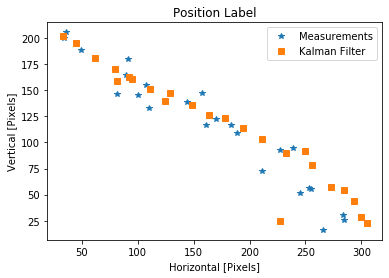

In [1]:
! make 
! mv TestTrack.csv TestTrackCPU.csv
import matplotlib.pyplot as plt
import pandas as pd


def plot_results(filename):
    df = pd.read_csv(filename)
    
    plot_1, ax = plt.subplots()

    ax.plot(df.Xmsaved.to_list(), df.Ymsaved.to_list(), '*', label="Measurements")
    ax.plot(df.Xhsaved.to_list(), df.Yhsaved.to_list(), 's', label="Kalman Filter")
    #ax.set(title="Velocity Label", xlabel="Time [sec]", ylabel="Velocity [M/s]")
    ax.set(title="Position Label", xlabel="Horizontal [Pixels]", ylabel="Vertical [Pixels]")
    ax.legend()

plot_results('TestTrackCPU.csv')


# GPU execution

In [2]:
! chmod 755 q; chmod 755 build_run.sh; if [ -x "$(command -v qsub)" ]; then ./q build_run.sh; else ./build_run.sh; fi
! mv TestTrack.csv TestTrackGPU.csv

plot_results('TestTrackKalmanGPU.csv')

Job has been submitted to Intel(R) DevCloud and will execute soon.

 If you do not see result in 60 seconds, please restart the Jupyter kernel:
 Kernel -> 'Restart Kernel and Clear All Outputs...' and then try again

Job ID                    Name             User            Time Use S Queue
------------------------- ---------------- --------------- -------- - -----
983678.v-qsvr-1            ...ub-singleuser u81855          00:01:11 R jupyterhub     
983737.v-qsvr-1            build_run.sh     u81855          00:16:18 R batch          
983738.v-qsvr-1            build_run.sh     u81855          00:14:38 R batch          
983739.v-qsvr-1            build_run.sh     u81855                 0 Q batch          
983741.v-qsvr-1            build_run.sh     u81855                 0 Q batch          
983743.v-qsvr-1            build_run.sh     u81855                 0 Q batch          
983744.v-qsvr-1            build_run.sh     u81855                 0 Q batch          
983745.v-qsvr-1       

NameError: name 'plot_results' is not defined